#Import Libraries

In [8]:
import torch # pytorch
import torch.nn as nn # for neural network layers
import torch.optim as optim # for optimization algorithm
import torchvision # for image processing
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Load Dataset

In [9]:
def get_data_loaders(batch_size = 64):
  transform = transforms.Compose([
      transforms.ToTensor(), # convert image to tensor
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # normalize rgb channels
      ])

  # Download CIFAR10 dataset and create training test dataset
  train_set = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = transform)
  test_set = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = transform)

  # dataloader
  train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True,)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = False)

  return train_loader, test_loader

#Visualize Dataset

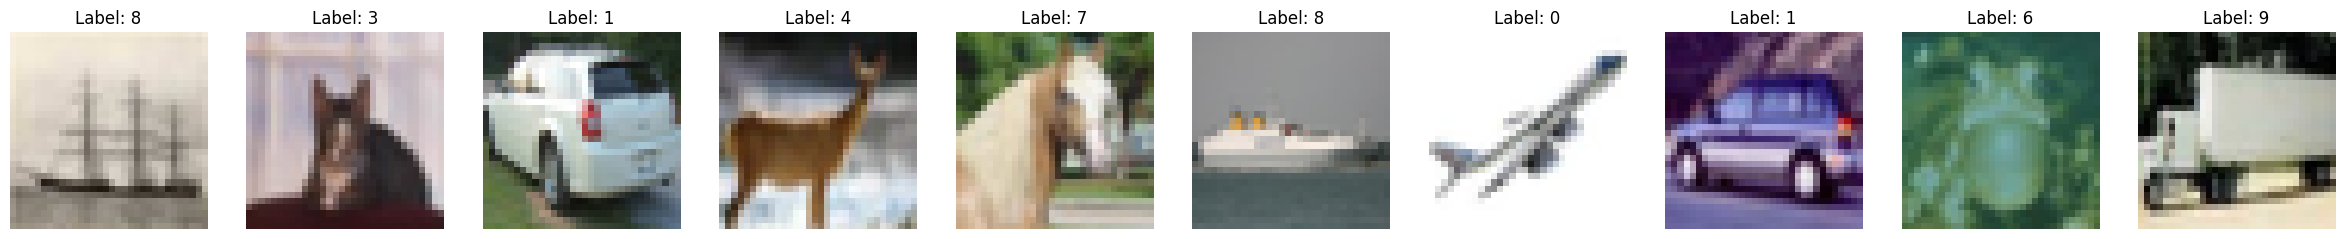

In [21]:
def imshow(img):
  # transform data before normalizing it
  img = img / 2 + 0.5 # the reverse of the normalization operation
  np_img = img.numpy() # Convert tensor to numpy array
  plt.imshow(np.transpose(np_img, (1, 2, 0))) # Displaying colors correctly for 3 channels

def get_sample_images(train_loader): # function to get sample images from dataset

  data_iter = iter(train_loader)
  images, labels = next(data_iter)
  return images, labels

def visualize(n):
  train_loader, test_loader = get_data_loaders()

  # n data visualizations
  images, labels = get_sample_images(train_loader)
  plt.figure(figsize=(n * 3, 3))
  for i in range(n):
    plt.subplot(1, n, i + 1)
    imshow(images[i]) # visualize
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
  plt.show()

#visualize(10)


#Build CNN Model

In [24]:
class CNN(nn.Module):

  def __init__(self):

    super(CNN, self).__init__()

    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1) # in_channels = rgb 3, out_channels = filtre sayisi , kernel_size = 3x3
    self.relu = nn.ReLU() # activition function
    self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2) # max pooling
    self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1) # Second convolution layer with 64 filters
    self.dropout = nn.Dropout(0.2) # dropout layer, dropout works at 20%
    self.fc1 = nn.Linear(in_features = 64 * 8 * 8, out_features = 128) # fully connected layer input = 4096, output = 128
    self.fc2 = nn.Linear(in_features = 128, out_features = 10) # output layer

  def forward(self, x):

    x = self.pool(self.relu(self.conv1(x))) # first convolution block: convolution, relu, pool
    x = self.pool(self.relu(self.conv2(x))) # second convolution block convolution, relu, pool
    x = x.view(-1, 64 * 8 * 8) # flatten
    x = self.dropout(self.relu(self.fc1(x))) # fully connected layer
    x = self.fc2(x) # output layer
    return x


#model = CNN().to(device)

#Define loss function and optimizer
define_loss_and_optimizer = lambda model: (
    nn.CrossEntropyLoss(), # multi class classification problem
    optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9) # stochastic gradient descent
)



#Training

Epoch 1/10, Loss: 2.0952
Epoch 2/10, Loss: 1.7528
Epoch 3/10, Loss: 1.5672
Epoch 4/10, Loss: 1.4336
Epoch 5/10, Loss: 1.3470
Epoch 6/10, Loss: 1.2774
Epoch 7/10, Loss: 1.2207
Epoch 8/10, Loss: 1.1709
Epoch 9/10, Loss: 1.1263
Epoch 10/10, Loss: 1.0860


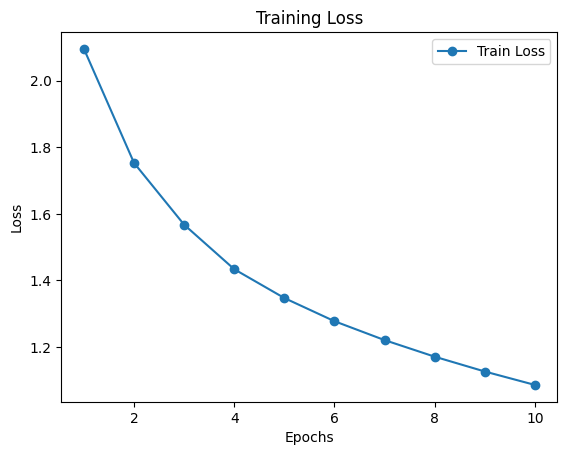

In [25]:
def train_model(model, train_loader, criterion, optimizer, epochs = 5):

  model.train() # Let's put the model in training mode
  train_losses = [] # Creating a list to store loss values

  for epoch in range(epochs): # Create a for loop for the specified number of epochs
      total_loss = 0 # total_loss to store the total loss value
      for images, labels in train_loader: # for loop to scan the entire training dataset
          images, labels = images.to(device), labels.to(device)

          optimizer.zero_grad() # resetting gradients
          outputs = model(images) # forward pro. (prediction) output = label, class
          loss = criterion(outputs, labels) # loss value calculation
          loss.backward() # backpropagation (gradient calculation)
          optimizer.step() # learning = parameter, i.e. weight update

          total_loss += loss.item()

      avg_loss = total_loss / len(train_loader) # average loss value
      train_losses.append(avg_loss)
      print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

  # loss graph
  plt.figure()
  plt.plot(range(1, epochs + 1), train_losses, marker = "o", linestyle = "-", label = "Train Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Training Loss")
  plt.legend()
  plt.show()

#train_loader, test_loader = get_data_loaders()
#model = CNN().to(device)
#criterion, optimizer = define_loss_and_optimizer(model)
#train_model(model, train_loader, criterion, optimizer, epochs = 10)

#Test

In [31]:
def test_model(model, test_loader, dataset_type):

  model.eval() # evaluation mode
  correct = 0 # correct guess counter
  total = 0 # total data counter

  with torch.no_grad(): # turn off gradient calculation
    for images, labels in test_loader:
        images,labels = images.to(device), labels.to(device) # move data to device

        outputs = model(images) # prediction
        _, predicted = torch.max(outputs, 1) # select the class with the highest probability
        total += labels.size(0) # update total data count
        correct += (predicted == labels).sum().item() # update the number of correct predictions

  print(f"{dataset_type} accuracy: {100 * correct / total}%") # print accuracy rate on screen

#test_model(model, test_loader, dataset_type = "test") # testacc = 62.55 %
#test_model(model, train_loader, dataset_type = "training") # trainingacc = 65.178 %

#Main

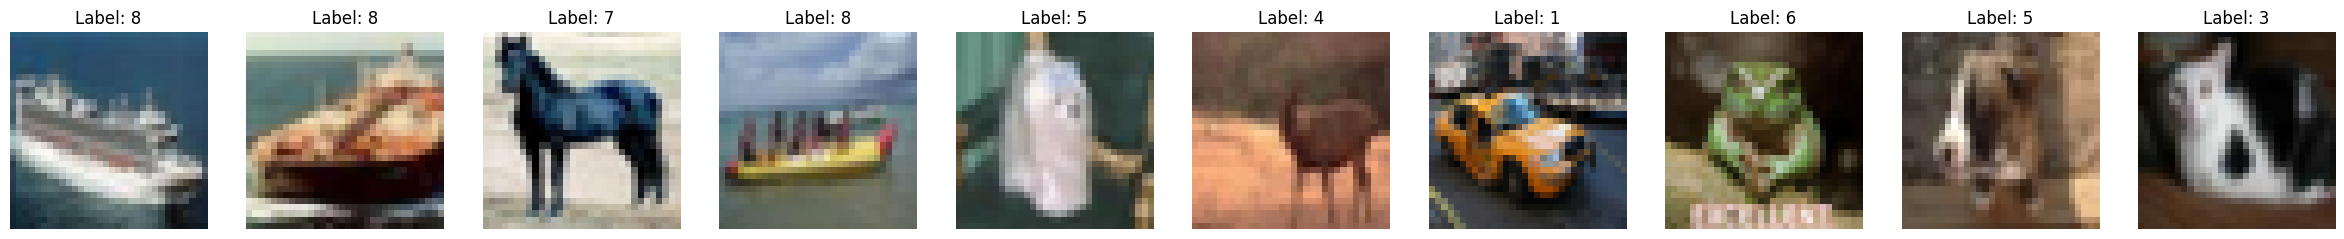

Epoch 1/10, Loss: 2.1401
Epoch 2/10, Loss: 1.7690
Epoch 3/10, Loss: 1.5652
Epoch 4/10, Loss: 1.4432
Epoch 5/10, Loss: 1.3594
Epoch 6/10, Loss: 1.2964
Epoch 7/10, Loss: 1.2383
Epoch 8/10, Loss: 1.1910
Epoch 9/10, Loss: 1.1450
Epoch 10/10, Loss: 1.1020


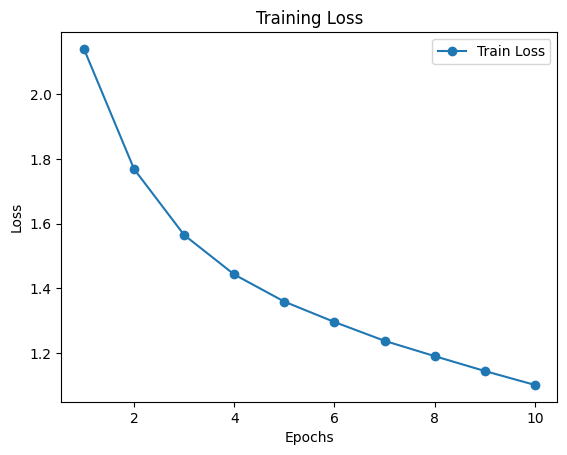

test accuracy: 61.11%
training accuracy: 63.886%


In [32]:
if __name__ == "__main__":

  # load dataset
  train_loader, test_loader = get_data_loaders()

  # visualization
  visualize(10)

  # training
  model = CNN().to(device)
  criterion, optimizer = define_loss_and_optimizer(model)
  train_model(model, train_loader, criterion, optimizer, epochs = 10)

  # test
  test_model(model, test_loader, dataset_type = "test") # testacc = 61.11 %
  test_model(model, train_loader, dataset_type = "training") # trainingacc = 63.886 %